In [1]:
# set up packages
import numpy as np
import matplotlib.pyplot as plt
import pickle
# import optuna
import time
import sys
import torch
import os
import random

from load_data_funs import load_data, gen_batch_data_fixations_choice, gen_batch_data_fixations_only, gen_batch_data_choice_only
from neural_nets import SimpleLSTM, SimpleMLP

is_array_job=False
on_cluster = False

if is_array_job:
    job_idx = int(os.environ["SLURM_ARRAY_TASK_ID"]) - 1
    train_setting= int(sys.argv[1])
else:
    job_idx = 0
    train_setting=0

# set the random seed.
random.seed(job_idx)

if on_cluster:
    sim_data_path = '/scratch/gpfs/erussek/RNN_project/optimal_fixation_sims'
    human_data_path = '/scratch/gpfs/erussek/RNN_project/human_trials.json'
else:
    sim_data_path = '/Users/evanrussek/Dropbox/Griffiths_Lab_Stuff/Data/RNNs/optimal_fixation_sims'
    human_data_path = '/Users/evanrussek/Dropbox/Griffiths_Lab_Stuff/Data/RNNs/human_trials.json'

    
train_data_funcs = [gen_batch_data_fixations_choice, gen_batch_data_fixations_only, gen_batch_data_choice_only]
this_data_func = train_data_funcs[train_setting]

best_lrs = [0.0019260129757659558, 0.0044066090959512735, .001]# 0.0001002995005652193]
best_hiddens = [97, 37, 50]

In [25]:
# function to test model...
def test(model, test_sim_data, criterion, device, batch_size, n_total_seq, gen_batch_data,human_data = False):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()
    
    n_total_seq = np.amin([1000, len(test_sim_data)])

    n_batches = int(np.round(n_total_seq / batch_size));

    loss_res = np.zeros((n_batches, 1), dtype=float)

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(n_batches):
            data, target = gen_batch_data(batch_size, batch_idx, test_sim_data, human_data=human_data)
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            
            to_keep = target != 0
            target = target[to_keep]
            output = output[to_keep]
            
            # target = target.argmax(dim=1)
            loss = criterion(output, target)  # is this just for the last batch?

            # store the loss
            loss_res[batch_idx] = loss.item()

    return np.mean(loss_res)



In [3]:
# load data
    # load data 
train_data_sim, test_data_sim, human_train_data,human_test_data = load_data(sim_data_path, human_data_path,this_seed=job_idx,split_human_data=True)
this_data_func = train_data_funcs[train_setting]


In [4]:
len(human_train_data), len(human_test_data)

(1976, 989)

In [7]:
# want to pretrain on some number of (1 epoch only) sequences of train_sim_data, and then train fully on some number of epochs of human_test_data...
# train on a 1 mil. examples, generate learning curves... 
batch_size  = 32
n_total_seq = 1.5e6
n_batches = int(np.round(n_total_seq/batch_size));
n_tests = int(np.ceil(n_batches/200)) - 1

input_sizes = [6,3,3]

torch.manual_seed(job_idx)

input_size  = input_sizes[train_setting] # this is the length of the input vector? #train_data_gen.n_symbols
hidden_size = best_hiddens[train_setting]
output_size = 3 # 

if train_setting == 2:
    model       = SimpleMLP(input_size, hidden_size, output_size)
else:
    model       = SimpleLSTM(input_size, hidden_size, output_size)

criterion   = torch.nn.MSELoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=best_lrs[train_setting])
start_time = time.time()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [42]:

def train_sim_then_human_with_intermediate_tests(model, train_data_sim, train_data_human, test_data_sim, test_data_human, criterion, optimizer, device, batch_size, n_sim_seq, n_human_epochs, gen_batch_data):

    n_human_seq = len(human_train_data) # about 2000

    # now we want to train on some number of 
    model.train()

    n_batches_sim = int(np.round(n_sim_seq/batch_size));
    n_batches_human = int(np.round(n_human_seq/batch_size));
    # first train on sim data...

    sim_loss_res=[]
    human_loss_res=[]
    train_num=[]


    # train on simulated data...
    print('Training on simulated data')
    for batch_idx in range(n_batches_sim):

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        data, target = gen_batch_data(batch_size, batch_idx, train_data_sim, human_data=False)
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

        # Perform the forward pass of the model
        output = model(data)

        # make sure target is correct type
        target = target.to(torch.float32)

        # filter out padding
        to_keep = target != 0
        target = target[to_keep]
        output = output[to_keep]

        # compute loss and backpropogate
        loss = criterion(output, target)  # Step
        optimizer.zero_grad()  # Step
        loss.backward()  # Step
        optimizer.step()  # Step

        # test every 100 batches... 

        # compute loss on both sim and human

        if ((batch_idx % 100) == 0) & (batch_idx > 0):
            sim_test_loss = test(model, test_data_sim, criterion, device, batch_size, n_total_seq, gen_batch_data, human_data=False)
            sim_loss_res.append(sim_test_loss)

            human_test_loss = test(model, test_data_human, criterion, device, batch_size, n_total_seq, gen_batch_data, human_data=True)
            human_loss_res.append(human_test_loss)

            train_num.append(32*(batch_idx+1))

            print('batch num' + str(batch_idx) + ' sim test loss: ' + str(sim_test_loss) + ' human test loss ' + str(human_test_loss))


    # now train on human data
    print('Training on human data')
    for epoch_idx in range(n_human_epochs):
        print('Human epoch: {}'.format(epoch_idx))
        for batch_idx in range(n_batches_human):

            this_batch_idx = n_batches_sim + n_batches_human*epoch_idx + batch_idx

            # Request a batch of sequences and class labels, convert them into tensors
            # of the correct type, and then send them to the appropriate device.
            data, target = gen_batch_data(batch_size, batch_idx, train_data_human, human_data=True)
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            # Perform the forward pass of the model
            output = model(data)

            # make sure target is correct type
            target = target.to(torch.float32)

            # filter out padding
            to_keep = target != 0
            target = target[to_keep]
            output = output[to_keep]

            # compute loss and backpropogate
            loss = criterion(output, target)  # Step
            optimizer.zero_grad()  # Step
            loss.backward()  # Step
            optimizer.step()  # Step

            # test every 100 batches... 

            # compute loss on both sim and human

            if ((this_batch_idx % 100) == 0) & (batch_idx > 0):
                sim_test_loss = test(model, test_data_sim, criterion, device, batch_size, n_total_seq, gen_batch_data, human_data=False)
                sim_loss_res.append(sim_test_loss)

                human_test_loss = test(model, test_data_human, criterion, device, batch_size, n_total_seq, gen_batch_data, human_data=True)
                human_loss_res.append(human_test_loss)

                train_num.append(32*(this_batch_idx+1))

                print('batch num' + str(batch_idx) + ' sim test loss: ' + str(sim_test_loss) + ' human test loss ' + str(human_test_loss))
            
    return np.array(sim_loss_res), np.array(human_loss_res), np.array(train_num), model



    

In [45]:
n_sim_seq = 0 # split this between 
n_human_epochs = 500 # multiply this by 2000 to get effective res... 
gen_batch_data = this_data_func
train_data_sim = train_data_sim
train_data_human = human_train_data
test_data_sim = test_data_sim
test_data_human = human_test_data

sim_loss_res, human_loss_res, train_num, model = train_sim_then_human_with_intermediate_tests(model, train_data_sim, train_data_human, test_data_sim, test_data_human, criterion, optimizer, device, batch_size, n_sim_seq, n_human_epochs, gen_batch_data)

Training on simulated data
Training on human data
Human epoch: 0
Human epoch: 1
batch num38 sim test loss: 5.342221444652926 human test loss 5.684050144687776
Human epoch: 2
Human epoch: 3
batch num14 sim test loss: 5.2950607269041 human test loss 5.715719607568556
Human epoch: 4
batch num52 sim test loss: 5.2580090492002425 human test loss 5.675458592753256
Human epoch: 5
Human epoch: 6
batch num28 sim test loss: 5.3774265627707205 human test loss 5.808531684260214
Human epoch: 7
Human epoch: 8
batch num4 sim test loss: 5.216174625581311 human test loss 5.724429622773202
Human epoch: 9
batch num42 sim test loss: 5.386243981699789 human test loss 5.75118746296052


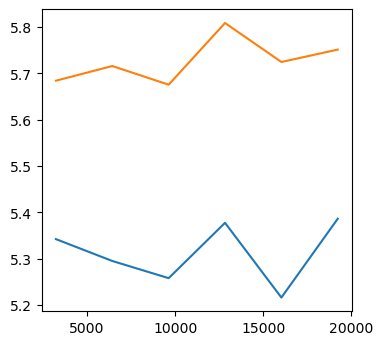

In [46]:
fig,ax = plt.subplots(1,figsize=(4,4),dpi=100)
ax.plot(train_num,sim_loss_res)
ax.plot(train_num, human_loss_res)

In [47]:
1e6/2000

500.0